In [90]:
'''
1. 针对有偏数据集（负样本对远大于正样本对）
除accuray指标外，还可以采用precision_score,recall_score,f1_score来更加精确的反应模型训练效果

2. 在判断样本对是否是正样本对时，我们可以尝试使用不同的阈值来预测模型准确率
def compute_accuracy(y_true, y_pred,threshold):
    pred = y_pred.ravel() < threshold
    print('pred:', pred)
    return np.mean(pred == y_true)
	
3. 以下代码将实现以下功能：
a. 使用model.predict_generator进行结果预测
b. 尝试在不同的阈值下，绘制模型precision_score,recall_score,f1_score
'''

"\n1. 针对有偏数据集（负样本对远大于正样本对）\n除accuray指标外，还可以采用precision_score,recall_score,f1_score来更加精确的反应模型训练效果\n\n2. 在判断样本对是否是正样本对时，我们可以尝试使用不同的阈值来预测模型准确率\ndef compute_accuracy(y_true, y_pred,threshold):\n    pred = y_pred.ravel() < threshold\n    print('pred:', pred)\n    return np.mean(pred == y_true)\n\t\n3. 以下代码将实现以下功能：\na. 使用model.predict_generator进行结果预测\nb. 尝试在不同的阈值下，绘制模型precision_score,recall_score,f1_score\n"

In [1]:
import os
import cv2
import csv
import tensorflow as tf
import numpy as np
import pandas as pd
import random
from keras import backend as K
from keras.preprocessing.image import img_to_array
from keras.optimizers import SGD,RMSprop
from keras.models import Model, Sequential,load_model
from keras.layers import Input,Concatenate, Add,Subtract,Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam,RMSprop,SGD

Using TensorFlow backend.


In [92]:
#set GPU to memory-growth mode

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [91]:
#define threshold_train
#images_paths='/root/tf-2.0/Siamese_Face_Detection/data/FaceV5_160_train.csv'
#images_data=pd.read_csv(images_paths)[:50000]
#images_data.to_csv('/root/tf-2.0/Siamese_Face_Detection/data/threshold_train.csv',index=None,header=None)

train_threshold_path='/root/tf-2.0/Siamese_Face_Detection/data/threshold_train.csv'
images_data=pd.read_csv(train_threshold_path,header=None)
images_data.columns=['pair1','pair2','labels']
labels=images_data['labels']
#labels[:10]

In [3]:
#define images generator

def processImg(filename,h,w):
    """
    :param filename: 图像的路径
    :return: 返回的是归一化矩阵
    """
    height=h
    width=w

    img = cv2.imread(filename)
    img = cv2.resize(img, (height, width))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img_to_array(img)
    img /= 255.
    return img

def generator(imgs, batch_size,input_shape):
    """
    自定义迭代器
    :param imgs: 列表，每个包含一对图片矩阵
    :param batch_size:
    :return:
    """
    h,w,c=input_shape
    while 1:
        li = imgs[:batch_size]
        pairs = []
        for i in li:
            img1 = i[0]
            img2 = i[1]
            im1 = cv2.imread(img1)
            im2 = cv2.imread(img2)
            if im1 is None or im2 is None:
                continue
            img1 = processImg(img1,h=h,w=w)
            img2 = processImg(img2,h=h,w=w)
            pairs.append([img1, img2])
        pairs = np.array(pairs)
        yield [pairs[:, 0], pairs[:, 1]]

In [6]:
input_shape=(160,160,3)
batch_size=20

rows_test=csv.reader(open(train_threshold_path, 'r'), delimiter=',')
imgs_test = list(rows_test)
steps=len(imgs_test)//batch_size
## define image pair generator
test_data=generator(imgs_test,batch_size,input_shape)

In [7]:
# calculate loss
def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

Siamese_softmax_model=load_model('/root/tf-2.0/Siamese_Face_Detection/h5/Siamese_softmax_02.h5',
                                 custom_objects={'contrastive_loss':contrastive_loss})

In [8]:
y_pred=Siamese_softmax_model.predict_generator(test_data,steps=steps,verbose=1)

2500/2500 [==============================] - 676s 270ms/step


In [19]:
#y_predict=pd.DataFrame(y_pred)
#y_predict.to_csv('/root/tf-2.0/Siamese_Face_Detection/data/predict.csv',header=None,index=None)

min_threshold=min(y_pred)
max_threshold=max(y_pred)
print(min_threshold,max_threshold)

[0.31549463] [1.8420728]


In [67]:
from sklearn.metrics import precision_score,recall_score,f1_score
import numpy as np

y_true=list(labels)
precision=[]
recall=[]
f1_score=[]
accuracy=[]
thresholds=np.arange(0.4,1.5,0.02)

def compute_prediction(y_pred,threshold):
    pred = y_pred.ravel() < threshold
    #pred=int(pred)
    return list(pred.astype(np.int32))

In [68]:
for threshold in thresholds:
    y_prediction=compute_prediction(y_pred,threshold)
    p=precision_score(y_true,y_prediction)
    r=recall_score(y_true,y_prediction)
    f1=2*p*r/(p+r)
    a=np.mean(np.array(y_prediction) == np.array(y_true))
    precision.append(p)
    recall.append(r)
    f1_score.append(f1)
    accuracy.append(a)

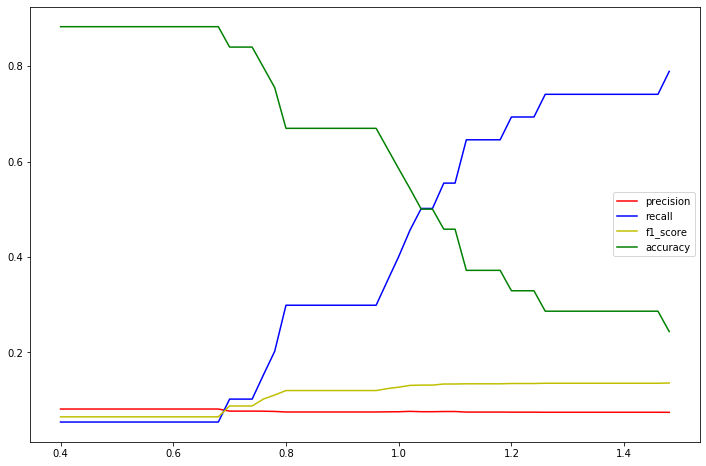

In [83]:
import matplotlib.pyplot as plt

#绘制准确率，召回率，F1_score,accuracy
plt.figure(figsize=(12,8))
plt.plot(thresholds,precision,'r',label='precision')
plt.plot(thresholds,recall,'b',label='recall')
plt.plot(thresholds,f1_score,'y',label='f1_score')
plt.plot(thresholds,accuracy,'g',label='accuracy')
plt.legend()
plt.show()